In [605]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [606]:
# load the dataset, check records format
data = pd.read_csv("DA_dataset.csv")
print(len(data))
data.head()

868


,Unnamed: 0,date,longitude,latitude,price_sqm,living_area_sqm
0,0,25-04-2018,25.12542,60.5894,3472,70.0
1,1,25-09-2018,25.12542,60.5894,5726,24.0
2,2,29-09-2018,25.12542,60.5894,4443,35.0
3,3,17-06-2018,25.12542,60.5894,3518,72.0
4,4,28-06-2018,25.12542,60.5894,3976,60.0


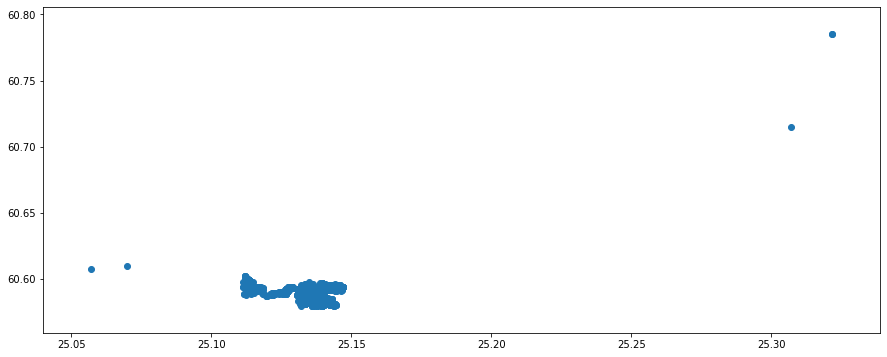

In [607]:
# Check geographical distribution for outliers
plt.rcParams["figure.figsize"] = [15,6]
plt.scatter(data['longitude'], data['latitude'])

863


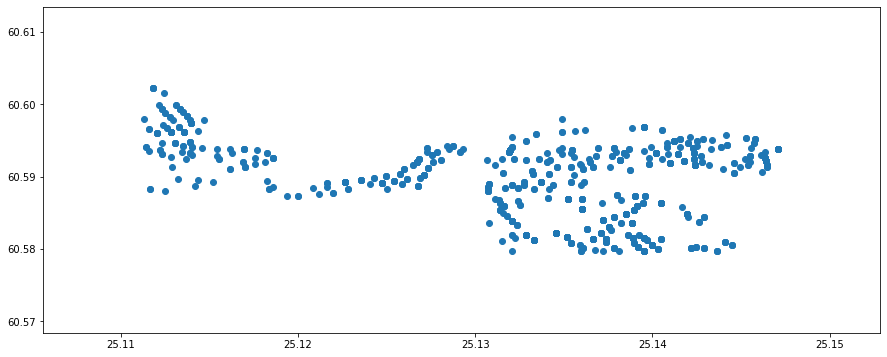

In [608]:
# remove a few clear outliers
data = data[25.1<data['longitude']]
data = data[data['longitude']<25.2]
print(len(data))
# print resulting geographical distribution
plt.rcParams["figure.figsize"] = [15,6]
plt.scatter(data['longitude'], data['latitude'])

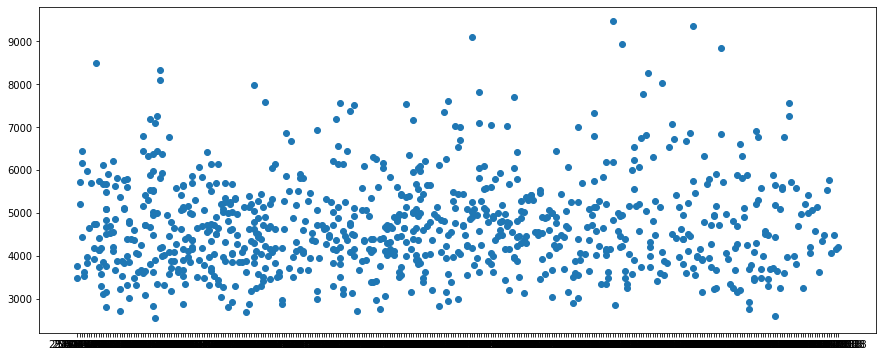

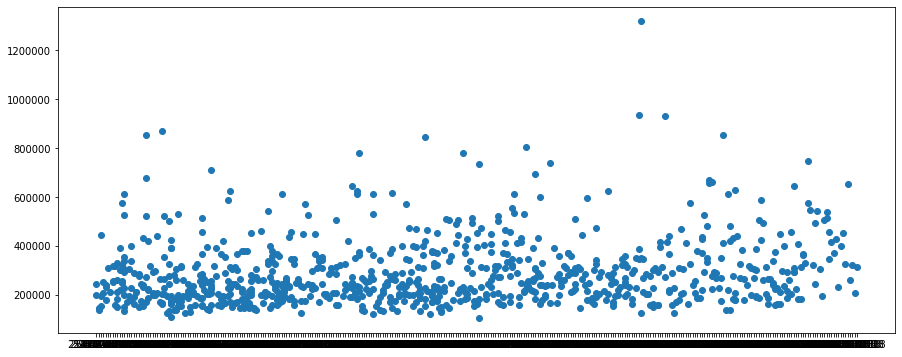

In [609]:
# evaluate distributions through time and of price per meter for outliers
plt.scatter(data['date'], data['price_sqm'])
plt.figure()
# also check total prices distribution
plt.scatter(data['date'], data['price_sqm']*data['living_area_sqm'])

862


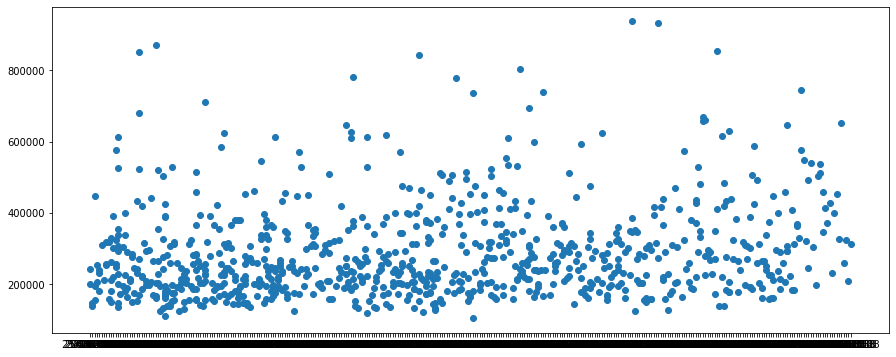

In [610]:
# datapoints are distributed densely enough through time; clean out total price outlier
data = data[data['price_sqm']*data['living_area_sqm']<1000000]
print(len(data))
plt.scatter(data['date'], data['price_sqm']*data['living_area_sqm'])

In [611]:
# See explanation for details

# compute logfunc parameters by pseudoinverse
def compute_logfunc_parameters(X, Y):
    A = np.matmul(np.linalg.inv(np.matmul(np.transpose(X), X)), np.matmul(np.transpose(X), Y))
    a = A[0][0]
    b = A[1][0]
    return a, b

# compose np matrices for pseudoinverse operation
def compose_XY(Xdata, Ydata):
    X = np.ones(shape=(len(Xdata), 2))
    X[:,1] = [np.log(area) for area in Xdata]
    Y = np.array(Ydata).reshape(len(Ydata), 1)
    return X, Y

# visualize distribution of price_sqm vs living_area_sqm and the average price curve as the red line
def show_average(Xdata, Ydata, a, b, mean=0, std=1):
    plotx = np.linspace(min(Xdata)-1,max(Xdata)+10,51)
    ploty = [mean + std*(a + b*np.log(each)) for each in plotx]
    plt.scatter(Xdata, Ydata)
    plt.plot(plotx,ploty,color="red")
    return True

8242.969367640268 -874.223807449016


True

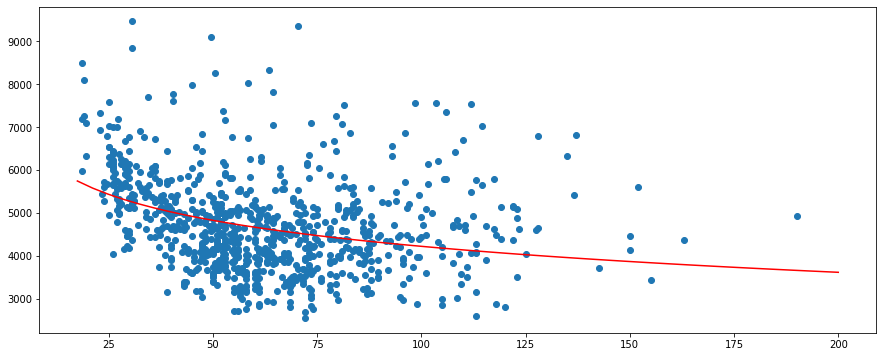

In [612]:
X, Y = compose_XY(data['living_area_sqm'],data['price_sqm'])
a, b = compute_logfunc_parameters(X, Y)
print(a, b)
show_average(data['living_area_sqm'],data['price_sqm'],a,b)

# In plot, the lower points are below the average curve, the cheaper are the deals, and vice versa

In [613]:
# compute parameter 'b' of logfunc for every data item. The bigger parameter, the more expensive is the price indicator
data['curve'] = (data['price_sqm']-a) / np.log(data['living_area_sqm'])

(array([ 3.,  4., 11., 11., 19., 20., 32., 46., 36., 55., 45., 43., 42.,
        57., 62., 47., 54., 48., 32., 31., 23., 24., 21., 12., 14.,  7.,
         5.,  9.,  7.,  7.,  4.,  5.,  4.,  3.,  2.,  5.,  2.,  1.,  2.,
         1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([-1390.4418322 , -1355.50527152, -1320.56871084, -1285.63215015,
        -1250.69558947, -1215.75902878, -1180.8224681 , -1145.88590741,
        -1110.94934673, -1076.01278604, -1041.07622536, -1006.13966467,
         -971.20310399,  -936.2665433 ,  -901.32998262,  -866.39342193,
         -831.45686125,  -796.52030056,  -761.58373988,  -726.64717919,
         -691.71061851,  -656.77405783,  -621.83749714,  -586.90093646,
         -551.96437577,  -517.02781509,  -482.0912544 ,  -447.15469372,
         -412.21813303,  -377.28157235,  -342.34501166,  -307.40845098,
         -272.47189029,  -237.53532961,  -202.59876892,  -167.66220824,
         -132.72564755,   -97.78908687,   -62.85252618,   -27.915965

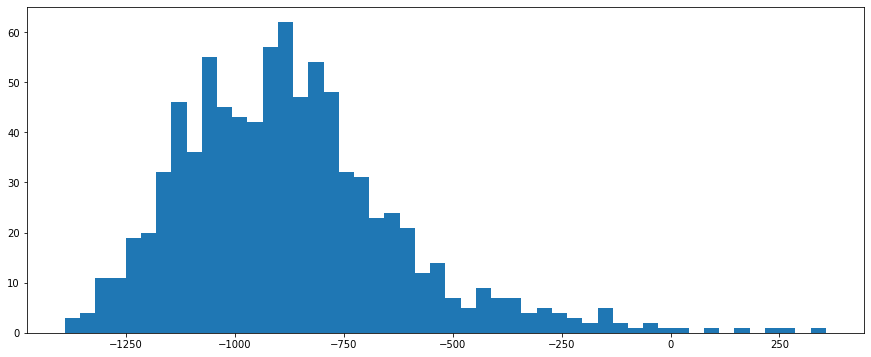

In [614]:
# histogram of 'curve' coefficients, which are 'classes' of prices. Smaller is cheaper.
plt.hist(data['curve'],bins=50)

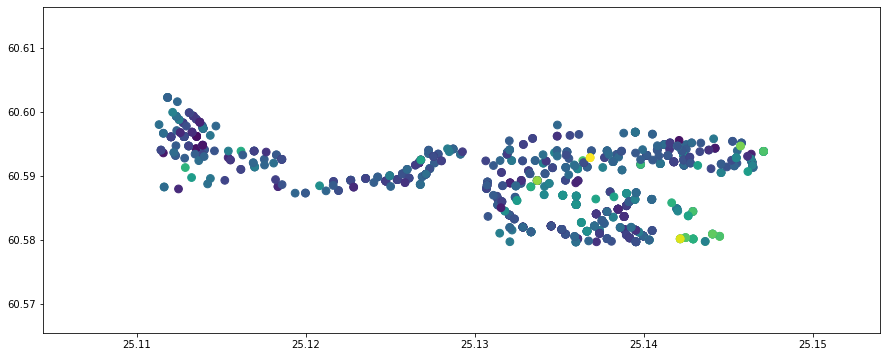

In [615]:
# geographical distribution with colors showing price class w.r.t. whole data average. The darker, the cheaper and vice versa
plt.scatter(data['longitude'], data['latitude'],c=(data['curve']), s=60)

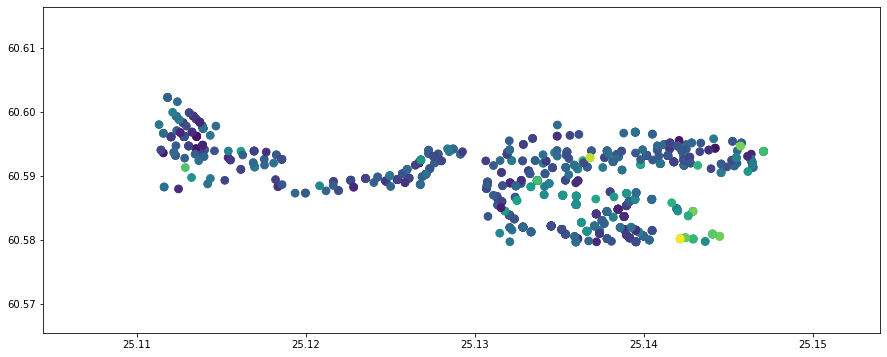

In [616]:
# plot of actual price per meter differences with regard to global average:
plt.scatter(data['longitude'], data['latitude'],c=data['price_sqm'] - b*np.log(data['living_area_sqm']), s=60)

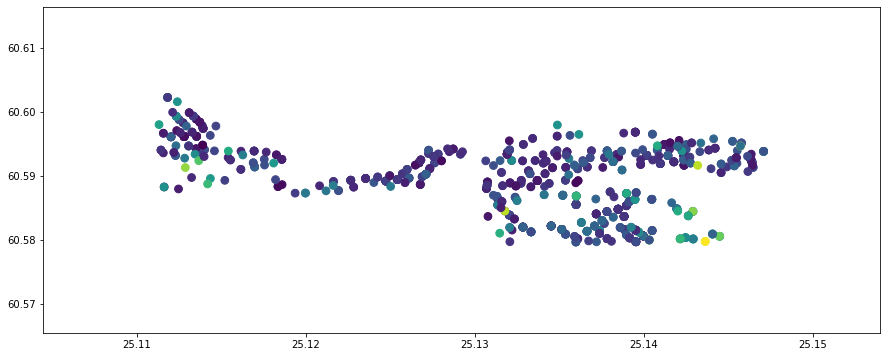

In [617]:
# Plot of total prices for apartments in the data (for fun). This shows areas where are the most expensive deals.
plt.scatter(data['longitude'], data['latitude'],c=data['living_area_sqm']*data['price_sqm'], s=60)

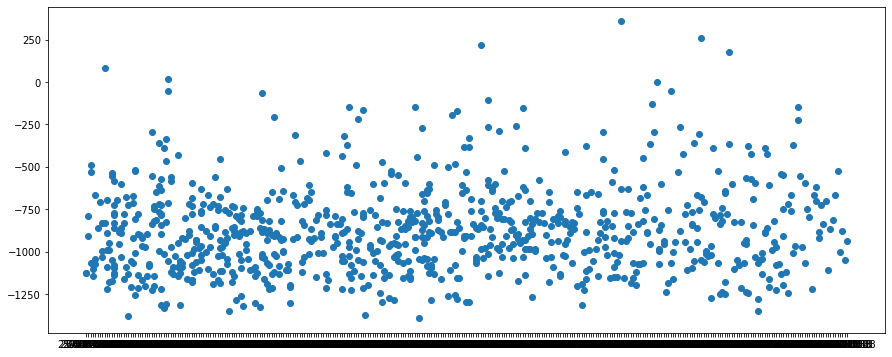

In [618]:
# distribution of price classes thrugh time
plt.scatter(data['date'], data['curve'])

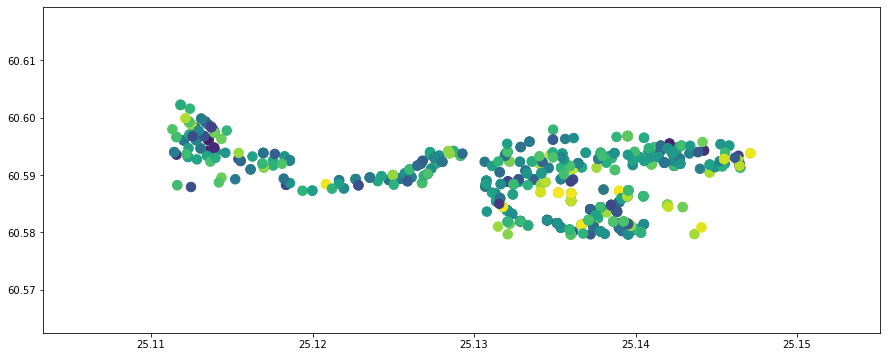

In [619]:
# distribution of price classes without the most expensive minority for better distinction in major areas
#(for fun, this is not used in any further computations)
data1 = data[data['curve']<-500]
plt.scatter(data1['longitude'], data1['latitude'],c=(data1['curve']), s=90)
# It is also possible to visualize any specific band of prices if needed

In [623]:
from random import random
    
def sample_single_starting_value():
    # For simplicity of demo, group starting parameters are sampled among the data items.
    # Generally, this should be done arbitrarily around the data manifold.
    # In the current case of 2 tasks optimizations at the same time, if sampling far from the data manifold, a group risks not getting any members from the beginning.
    index = np.random.randint(0,len(data))
    long = data['longitude'].iloc[index]
    lat = data['latitude'].iloc[index]
    curve = data['curve'].iloc[index]
    return [long,lat,curve]

def sample_starting_values(k):
    # In current model 3 parameters per class: core longitude, latitude and curve coefficient
    params = np.zeros(shape=(k,3))
    for i in range(0,k):
        params[i,:] = sample_single_starting_value()
    return params

def assign(parameters):
    # Assigns each dataitem a class(group) label
    labels = np.zeros(shape=(len(data)), dtype=int)
    costs = np.zeros(shape=(parameters.shape[0]))
    total_costs = 0
    for record in range(0, len(data)):
        for group in range(0,parameters.shape[0]):
            # Compute cost of item 'record' for being in group 'group'
            costs[group] = weights[0]*(parameters[group,0]-data['longitude'].iloc[record])**2 + weights[1]*(parameters[group,1]-data['latitude'].iloc[record])**2 + weights[2]*(parameters[group,2]-data['curve'].iloc[record])**2
        # assign group with the smallest cost
        labels[record] = np.argmin(costs)
        total_costs += min(costs)
    # results are all labels and total cost for the current labeling
    return labels, total_costs
    
def recalibrate(k, labels):
    # recompute group parameters by its members: mean longitude, latitude and curve parameter
    update = np.zeros(shape=(k,3))
    for group in range(0,k):
        long = np.mean(data['longitude'][labels==group])
        lat = np.mean(data['latitude'][labels==group])
        curve = np.mean(data['curve'][labels==group])
        update[group,:] = [long,lat,curve]
    return update

def visualize_clusters(labels):
    # helper function for result visualization over the geolocations
    plt.figure()
    plt.scatter(data['longitude'], data['latitude'],c=labels, s=60)
    plt.show()
    return True

In [627]:
# variances of longitude, latitude, curve parameter - to have a hint for k-means weight settings
print(np.var(data['longitude']),np.var(data['latitude']),np.var(data['curve']))

weights = [10000,10000,0.000002] # longitude, latitude, curve

# Note that here idea is not to normalize contribution of each feature to unity.
# E.g. we know that longitude and latitude should have similar significance because these represent geometrical locations
# disregarding that in data these features are not having same variance
print(np.array(weights)*[np.var(data['longitude']),np.var(data['latitude']),np.var(data['curve'])])

9.55055570537166e-05 2.92539826331566e-05 65779.3378032575
[0.95505557 0.29253983 0.13155868]


In [628]:
max_k = 15 # maximum of groups which will be viewed
experiments_per_k = 10 # miximum of experiments per group
parameters = np.zeros(shape=(max_k+1, experiments_per_k, max_k, 3)) # whole results logging structure
total_costs = np.zeros(shape=(max_k+1, experiments_per_k))
threshold = 0.01 # cost optimization threshold for early stopping
time_to_live = 50 # optimization iteration cap for late stopping

for k in range(2,max_k+1):
    for exp in range(0, experiments_per_k):
        parameters[k,exp,:k,:] = sample_starting_values(k)
        # print("parameters[k,exp,:k,:]", parameters[k,exp,:k,:])
        timer = 0
        while timer < time_to_live:
            labels, costs = assign(parameters[k,exp,:k,:])
            update = recalibrate(k, labels)
            # print(update.shape, parameters[k,exp,:k,:].shape)
            if np.sum((parameters[k,exp,:k,:]-update)**2) < threshold:
                # print(f'k{k}exp{exp}>Early stop with cost {costs} on iteration {timer}')
                break
            parameters[k,exp,:k,:] = update
            timer+=1
        total_costs[k,exp] = costs
        parameters[k,exp,:k,:] = update
print("Finished")

Finished



Figure 2 for curve groupe values:
[-946.56122956 -845.19231532]


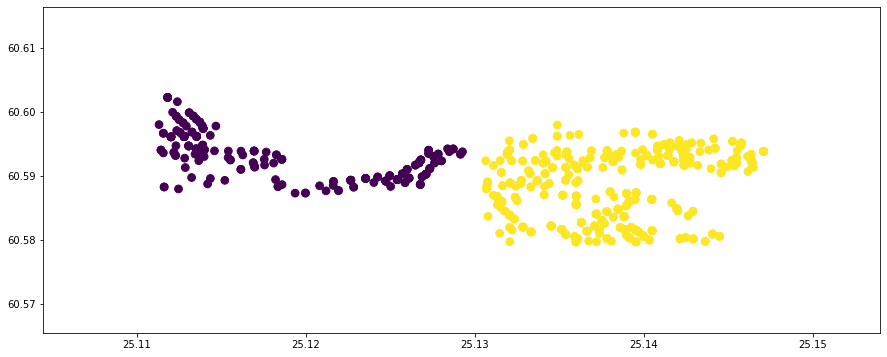


Figure 3 for curve groupe values:
[-947.30155805 -858.07084666 -835.74907286]


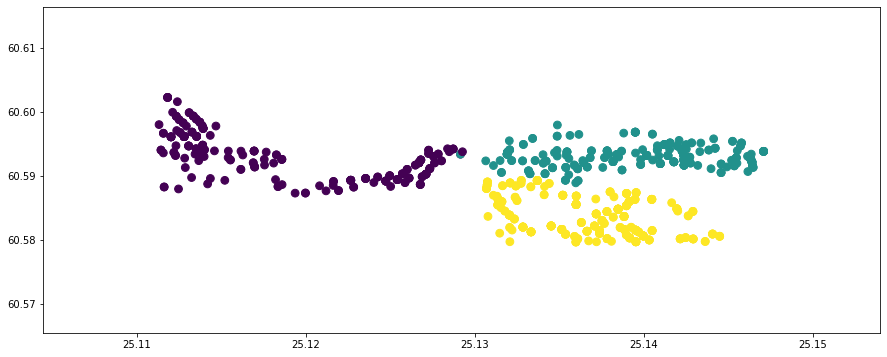


Figure 4 for curve groupe values:
[-961.04698094 -902.41580094 -850.24810184 -827.1822206 ]


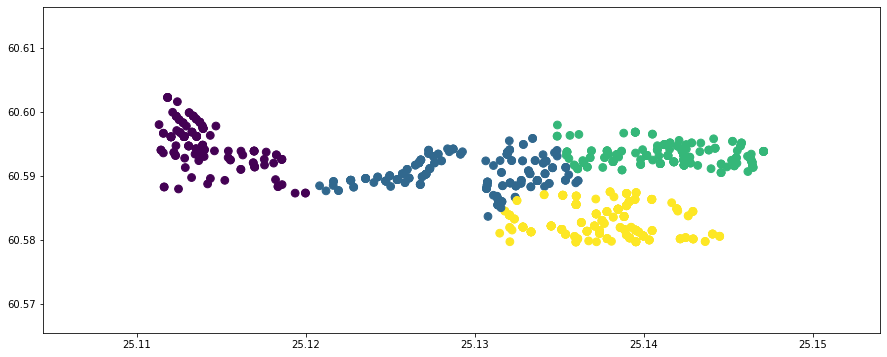


Figure 5 for curve groupe values:
[-970.31141329 -961.04698094 -919.92898157 -872.60243147 -445.24890873]


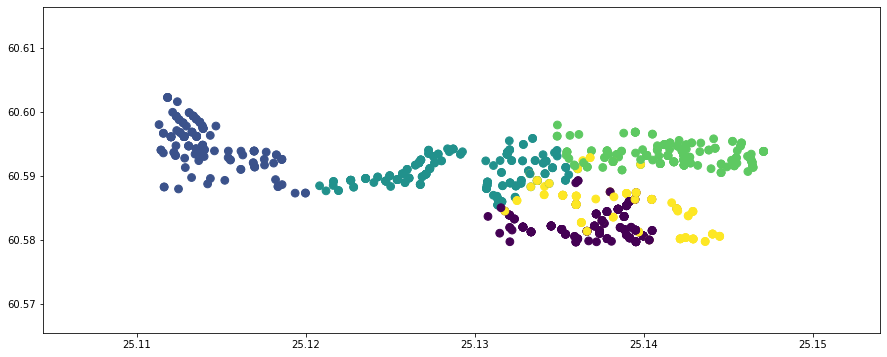


Figure 6 for curve groupe values:
[-968.76455433 -959.31048218 -930.65563728 -911.96781381 -866.29831918
 -440.25677957]


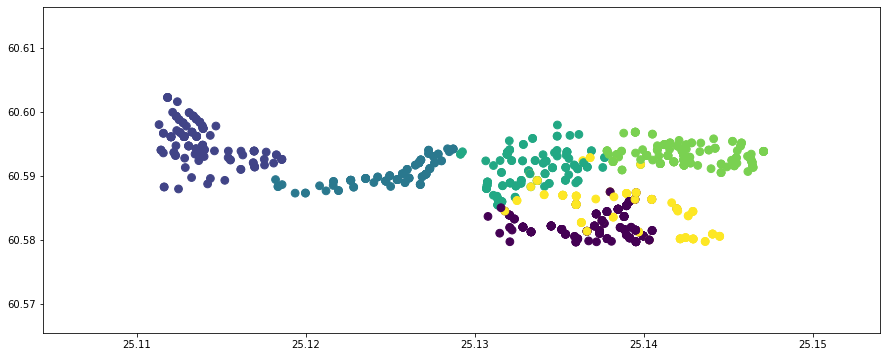


Figure 7 for curve groupe values:
[-969.90045622 -959.31048218 -930.65563728 -921.32028632 -866.29831918
 -535.78357986 -256.99056271]


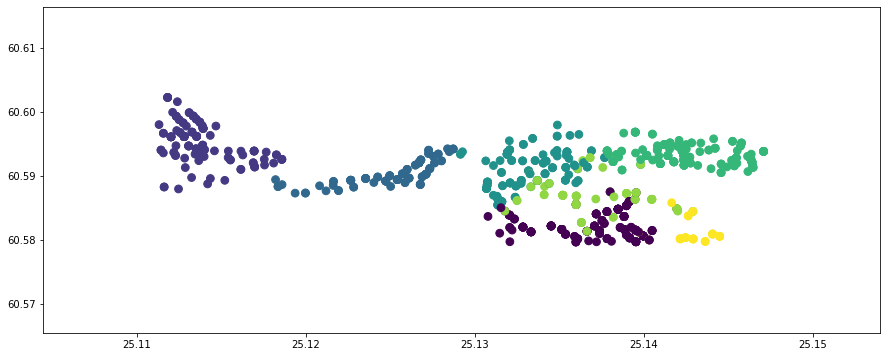


Figure 8 for curve groupe values:
[-982.27751166 -959.31048218 -931.07299089 -930.37948585 -921.7224751
 -865.16389298 -468.53061829 -257.28662598]


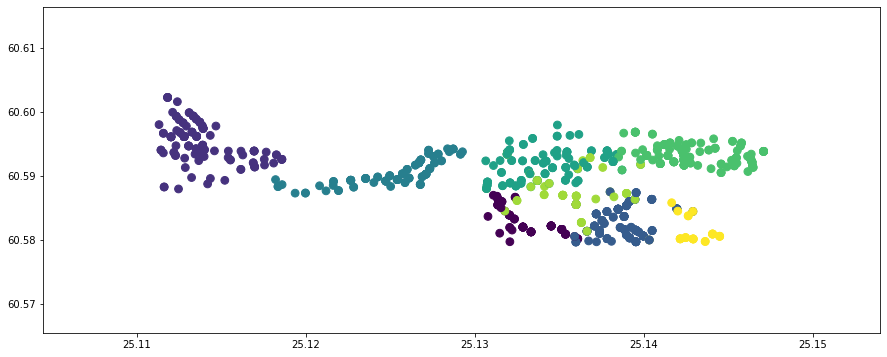


Figure 9 for curve groupe values:
[-999.39829959 -972.61290526 -940.30949707 -930.7757965  -925.80329718
 -898.81653935 -862.44348126 -469.61737678 -268.30596509]


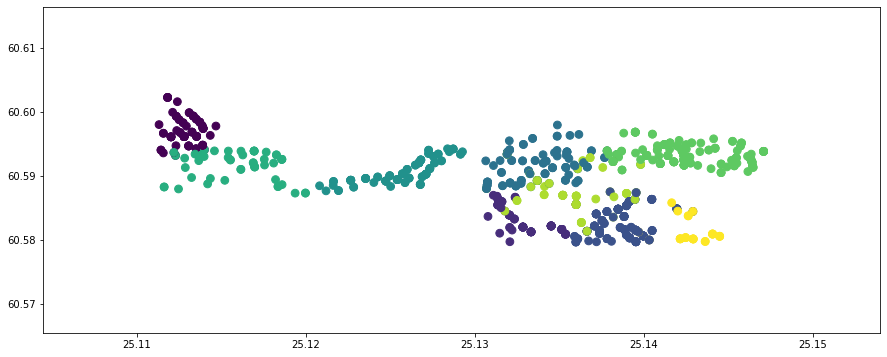


Figure 10 for curve groupe values:
[-989.22346248 -977.46976361 -970.50392828 -959.31048218 -930.65563728
 -917.62723317 -896.4919084  -597.1753491  -458.47156661 -255.52073657]


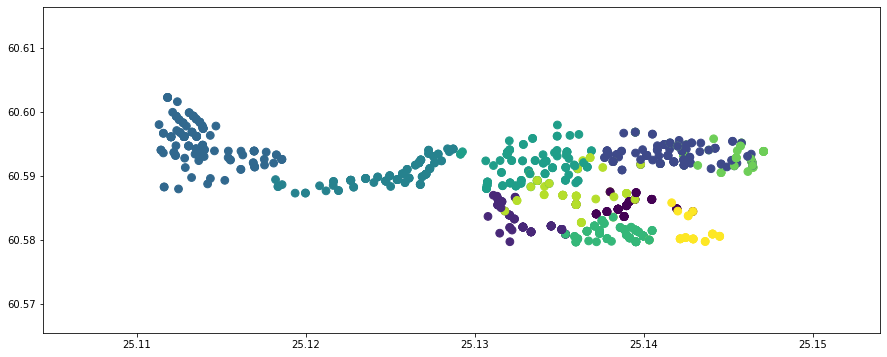


Figure 11 for curve groupe values:
[-1091.96885011  -996.53659137  -970.75036027  -940.98018783
  -929.93441089  -922.11213273  -884.02875676  -845.73963851
  -602.11664316  -463.55821677  -268.30596509]


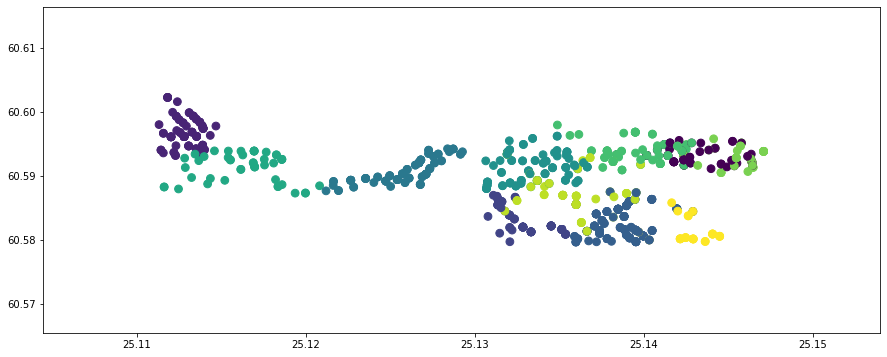


Figure 12 for curve groupe values:
[-1135.10614876 -1018.68800454  -976.24898863  -971.26112739
  -952.04573612  -921.90128634  -899.19857281  -873.54294988
  -802.50591984  -633.90880295  -457.96473789  -232.78848028]


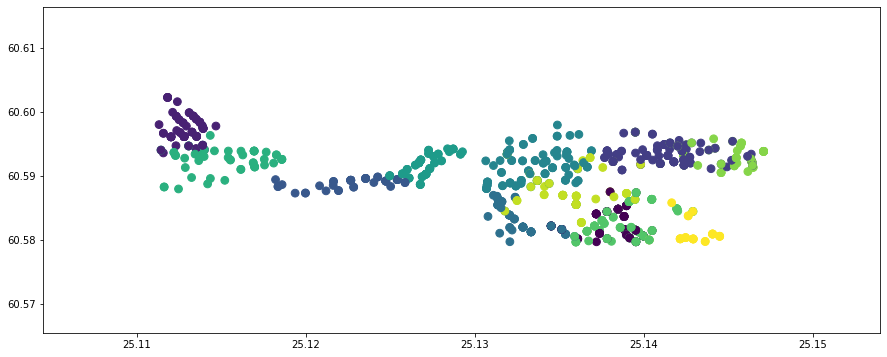


Figure 13 for curve groupe values:
[-1140.50078906 -1033.46975376  -996.53659137  -951.16163348
  -942.25057993  -930.38443578  -884.02875676  -843.80439864
  -814.10208439  -809.06470388  -612.41128332  -442.8852689
  -229.90139389]


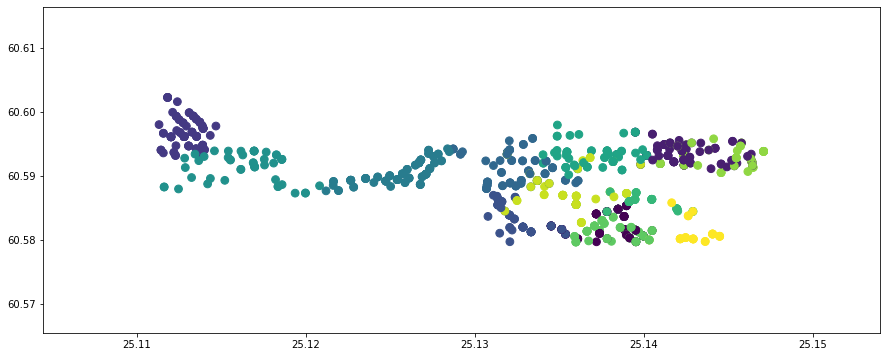


Figure 14 for curve groupe values:
[-1104.48734453 -1046.14468438 -1004.35538609  -996.53659137
  -974.82147173  -936.5779892   -884.02875676  -860.11716955
  -843.360264    -816.73754788  -744.5501155   -605.8466884
  -444.21056816  -229.90139389]


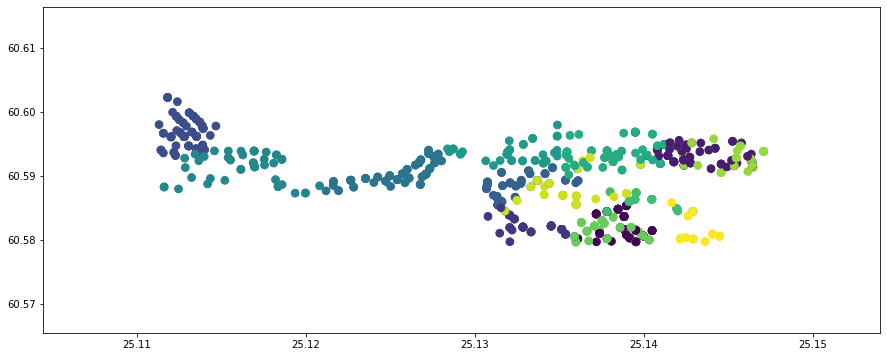


Figure 15 for curve groupe values:
[-1126.77753931 -1112.42867485 -1090.9149752  -1046.41255077
  -975.23625697  -929.93441089  -901.01831728  -881.80150428
  -821.24535428  -813.90930572  -754.29660706  -665.96360832
  -596.87257123  -450.61804609  -229.90139389]


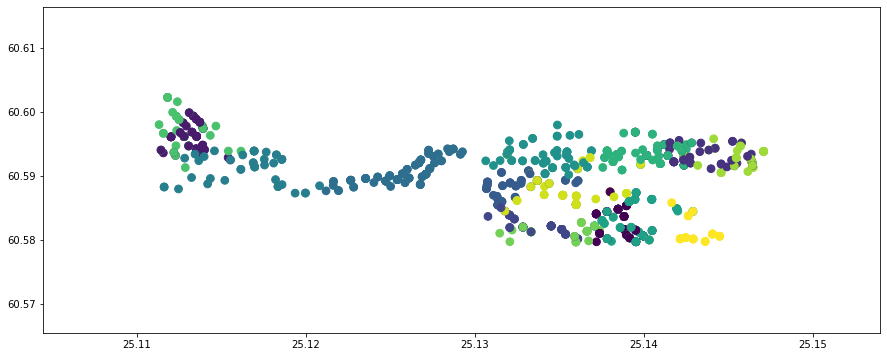

In [629]:
def reassign_labels_by_prices(parameters):
    labels, _ = assign(parameters)
    k = parameters.shape[0]
    sorted_label_markers = sorted(range(k), key=lambda each_k: parameters[each_k,2])
    labels = [sorted_label_markers.index(label) for label in labels]
    return labels

for k in range(2,max_k+1):
    # The lowest cost experiment for current number of groups, k
    best_exp_ind = np.argmin(total_costs[k,:])
    # label order is not corresponding to price; reassign order for better visibility
    labels = reassign_labels_by_prices(parameters[k,best_exp_ind,:k,:])
    print(f"\nFigure {k} for curve groupe values:") # {parameters[k,exp,:k,:]}
    print(np.sort(parameters[k,best_exp_ind,:k,2]))
    visualize_clusters(labels)
    #input("Press Enter to continue...")

In [630]:
# Task: save kodit postcodes in JSON file
# Choosing best result for 15 groups in this example
import json

kodit_postcodes = dict()
k = 15
best_exp_ind = np.argmin(total_costs[k,:])
labels = reassign_labels_by_prices(parameters[k,best_exp_ind,:k,:])

for group in range(0,k):
    kodit_postcodes[group] = [[data['longitude'].iloc[record],data['latitude'].iloc[record]] for record in range(len(data)) if labels[record]==group]
    print([data['curve'].iloc[record] for record in range(len(data)) if labels[record]==group], "\n\n")

# pricetags of records per group are printed to demonstarte how many records are in each group
    
with open('clusters.json', 'w') as json_file:  
    json.dump(kodit_postcodes, json_file)

[-1007.3195446530239, -1116.2924703327226, -1160.9474548355586, -1126.4435407634555, -1104.587711507524, -1069.0876232877106, -1256.013039560912, -1220.3026504178101, -1158.2404568725576, -1066.8131457324575, -989.8439342018611, -1050.7177514189634, -1133.0998608622988, -1132.1573541422608, -1066.8131457324575, -1148.551958402785, -1284.7274044583746, -1137.2967260011553, -1208.6557941153817, -1224.758216183935, -1206.5290416470077, -1199.3546810229852, -1284.248965875534, -1215.1786241805876, -1029.097660975908, -1152.8542891450074, -1279.9130914516784, -1042.6821257243148, -1134.8258460876489, -1243.2065551785581, -1158.2404568725576, -1158.2404568725576, -1349.3526084246053, -1194.945196854814, -1160.27248290569, -1073.5097418006756, -1298.2693069958532, -1078.8134088456088, -1117.0299842230027, -1168.4796860461577, -1133.9384646973306, -1203.0209073949848, -1010.063179269011, -1128.4946524012616, -972.0880891785396, -1053.678882519806, -1155.779348600217, -1108.3317631388763, -1031

In [631]:
# Task: compose SQL query to select the latest deal for the chosen group

k = 15
best_exp_ind = np.argmin(total_costs[k,:])
chosen_k = 10

# This assumes the name of the table is 'kodit', date is in some correct DATE format (not VARCHAR)
QUERY = f"SELECT * FROM\n(SELECT * FROM kodit WHERE {weights[0]}*({parameters[k,best_exp_ind,chosen_k,0]}-longitude)^2 + {weights[1]}*({parameters[k,best_exp_ind,chosen_k,1]}-latitude)^2 + {weights[2]}*({parameters[k,best_exp_ind,chosen_k,2]}-(price_sqm-{a})/LOG(living_area_sqm))^2 < LEAST("

for group in range(k):
    if group!=chosen_k:
        QUERY+=f"{weights[0]}*({parameters[k,best_exp_ind,group,0]}-longitude)^2 + {weights[1]}*({parameters[k,best_exp_ind,group,1]}-latitude)^2 + {weights[2]}*({parameters[k,best_exp_ind,group,2]}-(price_sqm-{a})/LOG(living_area_sqm))^2,"

# Delete last coma ',' and insert closing parenthesis for LEAST(), finish the command
QUERY = QUERY[:len(QUERY)-1] + ')) as cluster\nORDER BY date DESC\nLIMIT 1'

print(QUERY)

SELECT * FROM
(SELECT * FROM kodit WHERE 10000*(25.11659181814367-longitude)^2 + 10000*(60.59116624069767-latitude)^2 + 2e-06*(-901.0183172817681-(price_sqm-8242.969367640268)/LOG(living_area_sqm))^2 < LEAST(10000*(25.113216088472438-longitude)^2 + 10000*(60.59624696774193-latitude)^2 + 2e-06*(-1112.428674846179-(price_sqm-8242.969367640268)/LOG(living_area_sqm))^2,10000*(25.134113393322323-longitude)^2 + 10000*(60.59305331285715-latitude)^2 + 2e-06*(-881.801504280964-(price_sqm-8242.969367640268)/LOG(living_area_sqm))^2,10000*(25.133779558765635-longitude)^2 + 10000*(60.582236677272725-latitude)^2 + 2e-06*(-1046.4125507702956-(price_sqm-8242.969367640268)/LOG(living_area_sqm))^2,10000*(25.14561779691443-longitude)^2 + 10000*(60.5929756475-latitude)^2 + 2e-06*(-596.872571227365-(price_sqm-8242.969367640268)/LOG(living_area_sqm))^2,10000*(25.143006695970726-longitude)^2 + 10000*(60.58097170399999-latitude)^2 + 2e-06*(-229.90139388672043-(price_sqm-8242.969367640268)/LOG(living_area_sqm)

In [632]:
parameters[15,best_exp_ind,:k,:]

array([[   25.11321609,    60.59624697, -1112.42867485],
       [   25.13411339,    60.59305331,  -881.80150428],
       [   25.13377956,    60.58223668, -1046.41255077],
       [   25.1456178 ,    60.59297565,  -596.87257123],
       [   25.1430067 ,    60.5809717 ,  -229.90139389],
       [   25.13859957,    60.58303335, -1126.77753931],
       [   25.14291673,    60.59329694, -1090.9149752 ],
       [   25.13555434,    60.58128943,  -665.96360832],
       [   25.12576636,    60.59060743,  -929.93441089],
       [   25.13569508,    60.58762748,  -450.61804609],
       [   25.11659182,    60.59116624,  -901.01831728],
       [   25.13243545,    60.58832025,  -975.23625697],
       [   25.1401754 ,    60.5934115 ,  -813.90930572],
       [   25.11286881,    60.59723438,  -754.29660706],
       [   25.13939333,    60.58296477,  -821.24535428]])

2.302585092994046

0.9932517730102834

6.249610364415452
4.7185381807740425
5.930155658679245
6.151536333983701
5.8180054592196635
2.421908023948986
1.8890037704985296
2.326740375553568
2.326740375553568
1.844846388439347
3.9819999486170614
3.2670627530413405
2.12702973593906
3.835354213925662
4.5246977239585675
3.597558101146957
4.0993789815179404
6.150341385510791
7.929251570769639
5.965621375213626
6.023869032521816
7.08042502404494
6.379860035971338
5.380005289242703
6.678382318890877
6.916669191865367
6.561714271390494
6.219816740732963
6.1812162601213
2.2770184072320445
3.0523907273571638
2.6080955334743994
2.0581402130645396
3.4049162127682555
2.4369602437080693
1.5906198143733954
1.5468752268260144
1.5845098218738884
3.99492013038046
1.7739037248837835
14.318690897597142
13.722057645609269
12.954660904030039
13.983985013462895
12.330065179652387
11.532756092378522
13.169789405214072
12.531634984302627
4.778940230420773
4.593578589176069
4.237710803180658
4.484737445546897
3.5095580090191643
3.7142999438513016
2.8862